In [3]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import datetime
import warnings
warnings.filterwarnings('ignore')

## 构造数据

In [78]:
data = pd.read_csv('train.txt')
train_set, test_set = train_test_split(data, test_size=0.2, random_state=2020)

train_label = train_set['label']
del train_set['label']
test_label = test_set['label']
del test_set['label']
data_df = pd.concat((train_set, test_set))

sparse_feas = [col for col in data_df.columns if col[0] == 'C']
dense_feas = [col for col in data_df.columns if col[0] == 'I']

data_df[sparse_feas] = data_df[sparse_feas].fillna('-1')
data_df[dense_feas] = data_df[dense_feas].fillna(0)

for feat in sparse_feas:
    le = LabelEncoder()
    data_df[feat] = le.fit_transform(data_df[feat])

mms = MinMaxScaler()
data_df[dense_feas] = mms.fit_transform(data_df[dense_feas])

train = data_df[:train_set.shape[0]]
test = data_df[train_set.shape[0]:]

train['label'] = train_label
test['label'] = test_label

train_set, val_set = train_test_split(train, test_size=0.1, random_state=2020)

train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print(train_set.shape, val_set.shape, test.shape)
#这里需要把特征分成数值型和离散型，因为后面的模型里面离散型的特征需要embedding，而数值型的特征直接进入stacking层
data_df = pd.concat((train_set, val_set, test))
dense_feas = ['I'+str(i) for i in range(1,14)]
sparse_feas = ['C'+str(i) for i in range(1, 27)]
#定义一个稀疏特征的embedding映射，字段{key:value},key表示每个稀疏特征，value表示数据集data_df对应列的不同取值格数，作为embedding输入维度
sparse_feas_map = {}
for key in sparse_feas:
    sparse_feas_map[key] = data_df[key].nunique()

#把特征信息进行封装，建立模型的时候作为参数传入
feature_info = [dense_feas, sparse_feas, sparse_feas_map]

#把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(train_set.drop(columns='label').values).float(), torch.tensor(train_set['label']).float())
dl_val_dataset = TensorDataset(torch.tensor(val_set.drop(columns='label').values).float(), torch.tensor(val_set['label']).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=16)
dl_valid = DataLoader(dl_val_dataset, shuffle=True, batch_size=16)

#查看一下数据
for b in iter(dl_train):
    print(b[0].shape, b[1])
    break

(1439, 40) (160, 40) (400, 40)
torch.Size([16, 39]) tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])


## 建立模型

In [32]:
#python生成元素对测试，这个可以帮助我们定义一个列表的全连接层
a = [256, 128, 64]
list(zip(a[:-1], a[1:]))

[(256, 128), (128, 64)]

In [33]:
#定义一个全连接层的神经网络
class DNN(nn.Module):
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units:列表，每个元素表示每一层的神经单元个数，比如[256,128,64]，两层网络，第一层神经单元128个，第二层神经单元64个，第一个是输入维度
        dropout:失活率
        """
        super(DNN, self).__init__()
        #pytorch中线性层只有线性层，不带激活函数。这个要与tf里面的Dense区分开
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p=dropout)
    #前向传播中，需要遍历dnn_network,不要忘了加激活函数
    def forward(self, x):
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)
        x = self.dropout(x)
        return x

In [34]:
#测试下全连接的网络
hidden_units = [16, 8, 4, 2, 1]
dnn = DNN(hidden_units)
dnn

DNN(
  (dnn_network): ModuleList(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=4, bias=True)
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.0)
)

In [39]:
class ProductLayer(nn.Module):
    def __init__(self, mode, embed_dim, field_num, hidden_units):
        super(ProductLayer, self).__init__()
        self.mode = mode
        #product层，由于交叉这里分为两部分，一部分是单独的特征运算，也就是上面结构的z部分，一个是两两交叉，p部分，而p部分还分为了内积交叉和外积交叉
        #所以，这里需要自己定义参数张量进行计算
        #z部分的w,这里的神经单元个数是hidden_units[0], 上面我们说过，全连接层的第一层神经单元个数是hidden_units[1], 而0层是输入层的神经
        #单元个数，正好是product层的输出层
        self.w_z = nn.Parameter(torch.rand([field_num, embed_dim, hidden_units[0]]))
        
        #p部分，分内积和外积两种操作
        if mode == 'in':
            self.w_p = nn.Parameter(torch.rand([field_num, field_num, hidden_units[0]]))
        else:
            self.w_p = nn.Parameter(torch.rand([embed_dim, embed_dim, hidden_units[0]]))
        self.l_b = torch.rand([hidden_units[0], ], requires_grad=True)
    def forward(self, z, sparse_embeds):
        #lz部分
        l_z = torch.mm(z.reshape(z.shape[0], -1), self.w_z.permute((2, 0, 1)).reshape(self.w_z.shape[2], -1).t())#(None, hidden_units[0])
        
        #lp部分
        if self.mode == 'in':#in模式 内积操作 p就是两两embedding先内积得到的[field_dim, field_dim]的矩阵
            p = torch.matmul(sparse_embeds, sparse_embeds.permute((0,2,1))) #[None, field_num, field_num]
        else: #外积模式 这里的p矩阵是两两embedding先外积得到n*n个[embed_dim, embed_dim]的矩阵，然后对应位置求和得到最终的1个[embed_dim, embed_dim]的矩阵
            #所以这里实现的时候，可以先把sparse_embeds矩阵再field_num方向上先求和，然后再外积
            f_sum = torch.unsqueeze(torch.sum(sparse_embeds, dim=1), dim=1) #[None, 1, embed_dim]
            p = torch.matmul(f_sum.permute((0,2,1)), f_sum) #[None, embed_dim, embed_dim]
        l_p = torch.mm(p.reshape(p.shape[0], -1), self.w_p.permute((2,0,1)).reshape(self.w_p.shape[2], -1).t()) #[None, hidden_units[0]]
        output = l_p + l_z + self.l_b
        return output

In [43]:
#下面我们定义真正的PNN网络
#这里的逻辑是底层输入(类别型特征)->embedding层->product层->DNN->输出
class PNN(nn.Module):
    def __init__(self, feature_info, hidden_units, mode='in', dnn_dropout=0., embed_dim=10, outdim=1):
        """
        feature_info:特征信息(数值特征，类别特征，类别特征embedding映射)
        hidden_units:列表，全连接层的每一层神经单元个数，注意，第一层神经单元个数实际上是hidden_units[1], 因为hidden_units[0]是输入层
        dnn_dropout:Dropout层的失活比例
        embed_dim:embedding的维度m
        outdim:网络的输出维度
        """
        super(PNN, self).__init__()
        self.dense_feas, self.sparse_feas, self.sparse_feas_map = feature_info
        self.field_num = len(self.sparse_feas)
        self.dense_num = len(self.dense_feas)
        self.mode = mode
        self.embed_dim = embed_dim
        
        #embedding层，这里需要一个列表的形式，因为每个类别特征都需要embedding
        self.embed_layers = nn.ModuleDict({
            'embed_'+str(key):nn.Embedding(num_embeddings=val, embedding_dim=self.embed_dim) for key, val in self.sparse_feas_map.items()
        })
        
        #Product层
        self.product = ProductLayer(mode, embed_dim, self.field_num, hidden_units)
        
        #dnn层
        hidden_units[0] += self.dense_num
        self.dnn_network = DNN(hidden_units, dnn_dropout)
        self.dense_final = nn.Linear(hidden_units[-1], 1)
    def forward(self, x):
        dense_inputs, sparse_inputs = x[:,:13], x[:,13:] #数值型和类别型数据分开
        sparse_inputs = sparse_inputs.long() #需要转成长张量，这个是embedding的输入要求格式
        sparse_embeds = [self.embed_layers['embed_'+key](sparse_inputs[:,i]) for key, i in zip(self.sparse_feas_map.keys(), range(sparse_inputs.shape[1]))]
        #上面这个sparse_embeds的维度是[field_num, None, embed_dim]
        sparse_embeds = torch.stack(sparse_embeds)
        sparse_embeds = sparse_embeds.permute((1, 0, 2)) #[None, field_num, embed_dim] 注意此时空间不连续，下面改变形状不能用view，用reshape
        z = sparse_embeds
        
        #product层
        sparse_inputs = self.product(z, sparse_embeds)
        
        #把上面的连起来，注意此时要加上数值特征
        l1 = F.relu(torch.cat([sparse_inputs, dense_inputs], -1))
        #dnn_network
        dnn_x = self.dnn_network(l1)
        
        outputs = F.sigmoid(self.dense_final(dnn_x))
        return outputs

In [44]:
hidden_units = [256, 128, 64]
hidden_units_copy = hidden_units.copy()
net = PNN(feature_info, hidden_units, mode='in')
net

PNN(
  (embed_layers): ModuleDict(
    (embed_C1): Embedding(79, 10)
    (embed_C10): Embedding(908, 10)
    (embed_C11): Embedding(926, 10)
    (embed_C12): Embedding(1239, 10)
    (embed_C13): Embedding(824, 10)
    (embed_C14): Embedding(20, 10)
    (embed_C15): Embedding(819, 10)
    (embed_C16): Embedding(1159, 10)
    (embed_C17): Embedding(9, 10)
    (embed_C18): Embedding(534, 10)
    (embed_C19): Embedding(201, 10)
    (embed_C2): Embedding(252, 10)
    (embed_C20): Embedding(4, 10)
    (embed_C21): Embedding(1204, 10)
    (embed_C22): Embedding(7, 10)
    (embed_C23): Embedding(12, 10)
    (embed_C24): Embedding(729, 10)
    (embed_C25): Embedding(33, 10)
    (embed_C26): Embedding(554, 10)
    (embed_C3): Embedding(1293, 10)
    (embed_C4): Embedding(1043, 10)
    (embed_C5): Embedding(30, 10)
    (embed_C6): Embedding(7, 10)
    (embed_C7): Embedding(1164, 10)
    (embed_C8): Embedding(39, 10)
    (embed_C9): Embedding(2, 10)
  )
  (product): ProductLayer()
  (dnn_network):

In [45]:
#测试一下模型，确定模型是可以跑通的
for fea, label in iter(dl_train):
    print(fea.shape, label.shape)
    out = net(fea)
    print(out)
    break

torch.Size([16, 39]) torch.Size([16])
tensor([[7.4395e-07],
        [7.6509e-03],
        [4.4846e-04],
        [2.1721e-04],
        [1.4404e-07],
        [1.9756e-05],
        [7.2756e-06],
        [2.0074e-04],
        [2.6625e-05],
        [1.6862e-04],
        [7.7166e-03],
        [2.3469e-03],
        [2.0464e-07],
        [1.7575e-04],
        [5.6376e-05],
        [1.7268e-02]], grad_fn=<SigmoidBackward>)


## 模型的训练

In [46]:
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)
loss_func = nn.BCELoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.0001)
metric_func = auc
metric_name = 'auc'

In [49]:
epochs = 6
log_step_freq = 10
dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])
print('Start Training...')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========='*8+'%s'%nowtime)

for epoch in range(1, epochs+1):
    #训练阶段
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    for step, (features, labels) in enumerate(dl_train, 1):
        #梯度清零
        optimizer.zero_grad()
        #正向传播
        predictions = net(features)
        loss = loss_func(predictions, labels)
        try:    #这里就是如果当前批次里面的y只有一个类别，跳过去
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        #反向传播求梯度
        loss.backward()
        optimizer.step()
        #打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(('[step=%d] loss:%.3f, '+metric_name+':%.3f') % (step, loss_sum/step, metric_sum/step))
    
    #验证阶段
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    for val_step, (features, labels) in enumerate(dl_valid, 1):
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    #记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    #打印epoch级别日志
    print(('\nEPOCH=%d, loss=%.3f,' + metric_name + ' =%.3f, val_loss=%.3f. '+'val_'+metric_name+' =%.3f')%info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('\n'+'======='*8+'%s'%nowtime)
print('Finished Training...')

Start Training...
========================================================================2022-08-01 16:31:38
[step=10] loss:0.460, auc:0.743
[step=20] loss:0.503, auc:0.712
[step=30] loss:0.511, auc:0.706
[step=40] loss:0.467, auc:0.699
[step=50] loss:0.456, auc:0.714
[step=60] loss:0.486, auc:0.716
[step=70] loss:0.487, auc:0.712
[step=80] loss:0.487, auc:0.706
[step=90] loss:0.484, auc:0.708

EPOCH=1, loss=0.484,auc =0.708, val_loss=0.650. val_auc =0.609

========================================================2022-08-01 16:31:40
[step=10] loss:0.455, auc:0.705
[step=20] loss:0.424, auc:0.782
[step=30] loss:0.438, auc:0.768
[step=40] loss:0.448, auc:0.771
[step=50] loss:0.447, auc:0.779
[step=60] loss:0.462, auc:0.767
[step=70] loss:0.459, auc:0.764
[step=80] loss:0.468, auc:0.758
[step=90] loss:0.463, auc:0.768

EPOCH=2, loss=0.463,auc =0.768, val_loss=0.763. val_auc =0.597

========================================================2022-08-01 16:31:41
[step=10] loss:0.505, auc:0.682


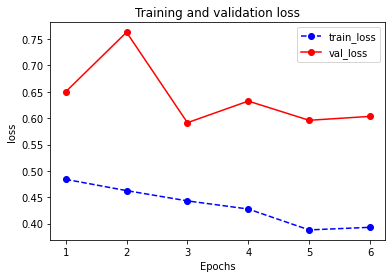

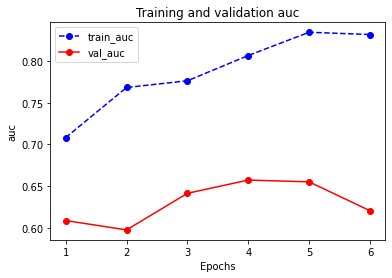

In [51]:
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'val_'+metric])
    plt.show()

#观察损失和准确率的变化
plot_metric(dfhistory, 'loss')
plot_metric(dfhistory, 'auc')

In [77]:
#预测
# test_label = test['label']
# del test['label']
y_pred_probs = net(torch.tensor(test.values).float())
#对于auc传参时 真实标签值必须在前面，第一个参数位置
test_auc = roc_auc_score(test_label.values, y_pred_probs.data.numpy())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(test_label.values, y_pred.data.numpy())
print('test_auc:%.3f, test_acc:%.3f' % (test_auc, test_acc))

test_auc:0.539, test_acc:0.725
